In [1]:
import os
import sys
import math
import json
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the Modules dir
project_path = "<PATH-TO-REPO>/BiMAEB-UDD-RUL/"
sys.path.insert(0, project_path)

from Modules.Models import AutoEncoder
from experimental_results.functions import (TURBOFAN_FEATURES_LIST, 
                       save_labeled_dataframe,
                       normalize_df, 
                       normalize_df_with_context,
                       get_model_reconstructions, 
                       get_latent_space_df)

from experimental_results.unsupervised_labeling_functions import (label_df, 
                                                                  plot_latent_space,
                                                                  plot_labels_recon_errors_and_threshold, 
                                                                  create_unsupervised_labeled_dataset)

# Define the number of samples that were defined as normal in the time-series

In [2]:
normal_op_len = 45
norm_op_len_as_pct = True

dataset = "FD004"
model_type = "AE"
prefix = "Pct" if norm_op_len_as_pct else "Len"


print(f"Normality: {normal_op_len} {prefix}")

Normality: 45 Pct


# Define Paths and File Names

In [3]:
model_name = f"normOp{prefix}{normal_op_len}_{model_type}"

# Define path's to data directories.
path_to_training_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/train"
path_to_testing_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/validation"

# Define CSV file names
csv_file_training = f"{dataset}_train.csv"
csv_file_testing = f"{dataset}_test.csv"

# Define paths
dataset_path_training = os.path.join(path_to_training_data_dir, csv_file_training)
dataset_path_testing = os.path.join(path_to_testing_data_dir, csv_file_testing)

path_to_model_state_dict = f"models/{model_name}_model_state_dict"

print(f"Model Path: {path_to_model_state_dict}")

Model Path: models/normOpPct45_AE_model_state_dict


# Load the Training and Testing Data. Normalize them too

In [4]:
print(f"Reading dataset \n{dataset_path_training}\n")
print(f"Reading dataset \n{dataset_path_testing}")

# Read data
df_training_not_normalized = pd.read_csv(dataset_path_training)
df_testing_not_normalized = pd.read_csv(dataset_path_testing)

print("\nNormalizing datasets...\n")
# Normalize Datasets
df_training_normalized = normalize_df(df=df_training_not_normalized, 
                                      model_features=TURBOFAN_FEATURES_LIST)

df_testing_normalized = normalize_df_with_context(df=df_testing_not_normalized, 
                                                  df_context=df_training_not_normalized, 
                                                  model_features=TURBOFAN_FEATURES_LIST)
print("Done!")

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train/FD004_train.csv

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation/FD004_test.csv

Normalizing datasets...

Done!


In [5]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device: {}".format(device))

Using Device: cpu


# Set Model and Data Parameters. 
`window_size` is a variable that tells us how many samples in each sample. 
`latent_size` is a variable that defines the latent space size.

In [6]:
window_size = 1
latent_size = 16
ts_number_features = len(TURBOFAN_FEATURES_LIST)

print(f"Latent Size: {latent_size}")
print(f"Number ts features: {ts_number_features}")

Latent Size: 16
Number ts features: 24


# Load the Trained Model

In [7]:
model = AutoEncoder(ts_number_features=ts_number_features,
                    latent_size=latent_size,
                    device=device,
                    model_name="",
                    metrics_dir="model")

print(f"Reading model at '{path_to_model_state_dict}'")
model.load_state_dict(torch.load(path_to_model_state_dict, map_location=torch.device(device)))

Reading model at 'models/normOpPct45_AE_model_state_dict'


<All keys matched successfully>

# Label Both Training and Testing Data With the Model

In [8]:
# Label Training Data!
num_contiguous_anomalous_samples = 3
num_stds = 3
df_unsuperivsed_labels_training, unit_thresholds_dict = create_unsupervised_labeled_dataset(
                                                            model=model, 
                                                            df=df_training_normalized, 
                                                            identifier_col="unit", 
                                                            cycle_col="cycle", 
                                                            fault_col="fault",
                                                            features_list=TURBOFAN_FEATURES_LIST,
                                                            normal_op_len=normal_op_len, 
                                                            normal_op_len_as_pct=norm_op_len_as_pct,
                                                            num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                                            num_stds=num_stds)

Unit 1
	Training Samples:    145
	Normal Samples:      144
	Abnormal Samples:    32

Unit 2
	Training Samples:    135
	Normal Samples:      140
	Abnormal Samples:    24

Unit 3
	Training Samples:    139
	Normal Samples:      120
	Abnormal Samples:    48

Unit 4
	Training Samples:    124
	Normal Samples:      72
	Abnormal Samples:    78

Unit 5
	Training Samples:    87
	Normal Samples:      63
	Abnormal Samples:    43

Unit 6
	Training Samples:    149
	Normal Samples:      146
	Abnormal Samples:    36

Unit 7
	Training Samples:    100
	Normal Samples:      86
	Abnormal Samples:    35

Unit 8
	Training Samples:    104
	Normal Samples:      86
	Abnormal Samples:    40

Unit 9
	Training Samples:    151
	Normal Samples:      140
	Abnormal Samples:    43

Unit 10
	Training Samples:    160
	Normal Samples:      146
	Abnormal Samples:    48

Unit 11
	Training Samples:    136
	Normal Samples:      100
	Abnormal Samples:    65

Unit 12
	Training Samples:    123
	Normal Samples:      118
	Abnorma

Unit 109
	Training Samples:    147
	Normal Samples:      136
	Abnormal Samples:    42

Unit 110
	Training Samples:    84
	Normal Samples:      80
	Abnormal Samples:    22

Unit 111
	Training Samples:    134
	Normal Samples:      131
	Abnormal Samples:    32

Unit 112
	Training Samples:    153
	Normal Samples:      145
	Abnormal Samples:    42

Unit 113
	Training Samples:    83
	Normal Samples:      80
	Abnormal Samples:    21

Unit 114
	Training Samples:    73
	Normal Samples:      70
	Abnormal Samples:    18

Unit 115
	Training Samples:    59
	Normal Samples:      45
	Abnormal Samples:    27

Unit 116
	Training Samples:    155
	Normal Samples:      154
	Abnormal Samples:    35

Unit 117
	Training Samples:    154
	Normal Samples:      138
	Abnormal Samples:    50

Unit 118
	Training Samples:    245
	Normal Samples:      212
	Abnormal Samples:    86

Unit 119
	Training Samples:    85
	Normal Samples:      64
	Abnormal Samples:    38

Unit 120
	Training Samples:    80
	Normal Samples:   

Unit 220
	Training Samples:    91
	Normal Samples:      71
	Abnormal Samples:    40

Unit 221
	Training Samples:    124
	Normal Samples:      104
	Abnormal Samples:    46

Unit 222
	Training Samples:    91
	Normal Samples:      95
	Abnormal Samples:    16

Unit 223
	Training Samples:    112
	Normal Samples:      113
	Abnormal Samples:    22

Unit 224
	Training Samples:    121
	Normal Samples:      96
	Abnormal Samples:    51

Unit 225
	Training Samples:    189
	Normal Samples:      200
	Abnormal Samples:    29

Unit 226
	Training Samples:    88
	Normal Samples:      65
	Abnormal Samples:    41

Unit 227
	Training Samples:    130
	Normal Samples:      131
	Abnormal Samples:    26

Unit 228
	Training Samples:    126
	Normal Samples:      111
	Abnormal Samples:    42

Unit 229
	Training Samples:    126
	Normal Samples:      92
	Abnormal Samples:    62

Unit 230
	Training Samples:    113
	Normal Samples:      105
	Abnormal Samples:    32

Unit 231
	Training Samples:    88
	Normal Samples: 

In [9]:
len(df_unsuperivsed_labels_training.query("fault==1")["unit"].unique())

249

In [10]:
df_unsupervised_labels_testing = create_unsupervised_labeled_dataset(
                                    model=model, 
                                    df=df_testing_normalized, 
                                    identifier_col="unit", 
                                    cycle_col="cycle", 
                                    fault_col="fault",
                                    features_list=TURBOFAN_FEATURES_LIST,
                                    normal_op_len=0, 
                                    normal_op_len_as_pct=norm_op_len_as_pct,
                                    num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                    num_stds=num_stds, 
                                    unit_thresholds_dict=unit_thresholds_dict)

Unit 1
	Training Samples:    0
	Normal Samples:      230
	Abnormal Samples:    0

Unit 2
	Training Samples:    0
	Normal Samples:      153
	Abnormal Samples:    0

Unit 3
	Training Samples:    0
	Normal Samples:      141
	Abnormal Samples:    0

Unit 4
	Training Samples:    0
	Normal Samples:      208
	Abnormal Samples:    0

Unit 5
	Training Samples:    0
	Normal Samples:      51
	Abnormal Samples:    0

Unit 6
	Training Samples:    0
	Normal Samples:      146
	Abnormal Samples:    0

Unit 7
	Training Samples:    0
	Normal Samples:      54
	Abnormal Samples:    0

Unit 8
	Training Samples:    0
	Normal Samples:      211
	Abnormal Samples:    37

Unit 9
	Training Samples:    0
	Normal Samples:      284
	Abnormal Samples:    0

Unit 10
	Training Samples:    0
	Normal Samples:      23
	Abnormal Samples:    0

Unit 11
	Training Samples:    0
	Normal Samples:      82
	Abnormal Samples:    0

Unit 12
	Training Samples:    0
	Normal Samples:      251
	Abnormal Samples:    19

Unit 13
	Traini

Unit 100
	Training Samples:    0
	Normal Samples:      183
	Abnormal Samples:    13

Unit 101
	Training Samples:    0
	Normal Samples:      135
	Abnormal Samples:    31

Unit 102
	Training Samples:    0
	Normal Samples:      392
	Abnormal Samples:    51

Unit 103
	Training Samples:    0
	Normal Samples:      145
	Abnormal Samples:    0

Unit 104
	Training Samples:    0
	Normal Samples:      65
	Abnormal Samples:    0

Unit 105
	Training Samples:    0
	Normal Samples:      351
	Abnormal Samples:    0

Unit 106
	Training Samples:    0
	Normal Samples:      148
	Abnormal Samples:    0

Unit 107
	Training Samples:    0
	Normal Samples:      121
	Abnormal Samples:    0

Unit 108
	Training Samples:    0
	Normal Samples:      145
	Abnormal Samples:    0

Unit 109
	Training Samples:    0
	Normal Samples:      66
	Abnormal Samples:    0

Unit 110
	Training Samples:    0
	Normal Samples:      348
	Abnormal Samples:    0

Unit 111
	Training Samples:    0
	Normal Samples:      332
	Abnormal Sample

Unit 203
	Training Samples:    0
	Normal Samples:      87
	Abnormal Samples:    0

Unit 204
	Training Samples:    0
	Normal Samples:      19
	Abnormal Samples:    0

Unit 205
	Training Samples:    0
	Normal Samples:      95
	Abnormal Samples:    0

Unit 206
	Training Samples:    0
	Normal Samples:      193
	Abnormal Samples:    98

Unit 207
	Training Samples:    0
	Normal Samples:      179
	Abnormal Samples:    0

Unit 208
	Training Samples:    0
	Normal Samples:      180
	Abnormal Samples:    0

Unit 209
	Training Samples:    0
	Normal Samples:      161
	Abnormal Samples:    10

Unit 210
	Training Samples:    0
	Normal Samples:      135
	Abnormal Samples:    0

Unit 211
	Training Samples:    0
	Normal Samples:      206
	Abnormal Samples:    0

Unit 212
	Training Samples:    0
	Normal Samples:      261
	Abnormal Samples:    0

Unit 213
	Training Samples:    0
	Normal Samples:      267
	Abnormal Samples:    21

Unit 214
	Training Samples:    0
	Normal Samples:      102
	Abnormal Samples

In [11]:
len(df_unsupervised_labels_testing.query("fault==1")["unit"].unique())

58

# Save Data to Their Respective Directories

In [12]:
# Create the path where to save the DataFrame
file_name_for_labeled_training_data = csv_file_training[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_training_data, 
                       save_path=path_to_training_data_dir,
                       df_labeled=df_unsuperivsed_labels_training, 
                       df_unlabeled=df_training_not_normalized)

Saved 'FD004_train_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train'


In [13]:
file_name_for_labeled_testing_data = csv_file_testing[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_testing_data, 
                       save_path=path_to_testing_data_dir,
                       df_labeled=df_unsupervised_labels_testing, 
                       df_unlabeled=df_testing_not_normalized)

Saved 'FD004_test_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation'


In [14]:
df_latent_space = get_latent_space_df(model=model, 
                                      df=df_unsuperivsed_labels_training, 
                                      unit_col_identifier_name="unit",
                                      cycle_col="cycle",
                                      features_list=TURBOFAN_FEATURES_LIST)

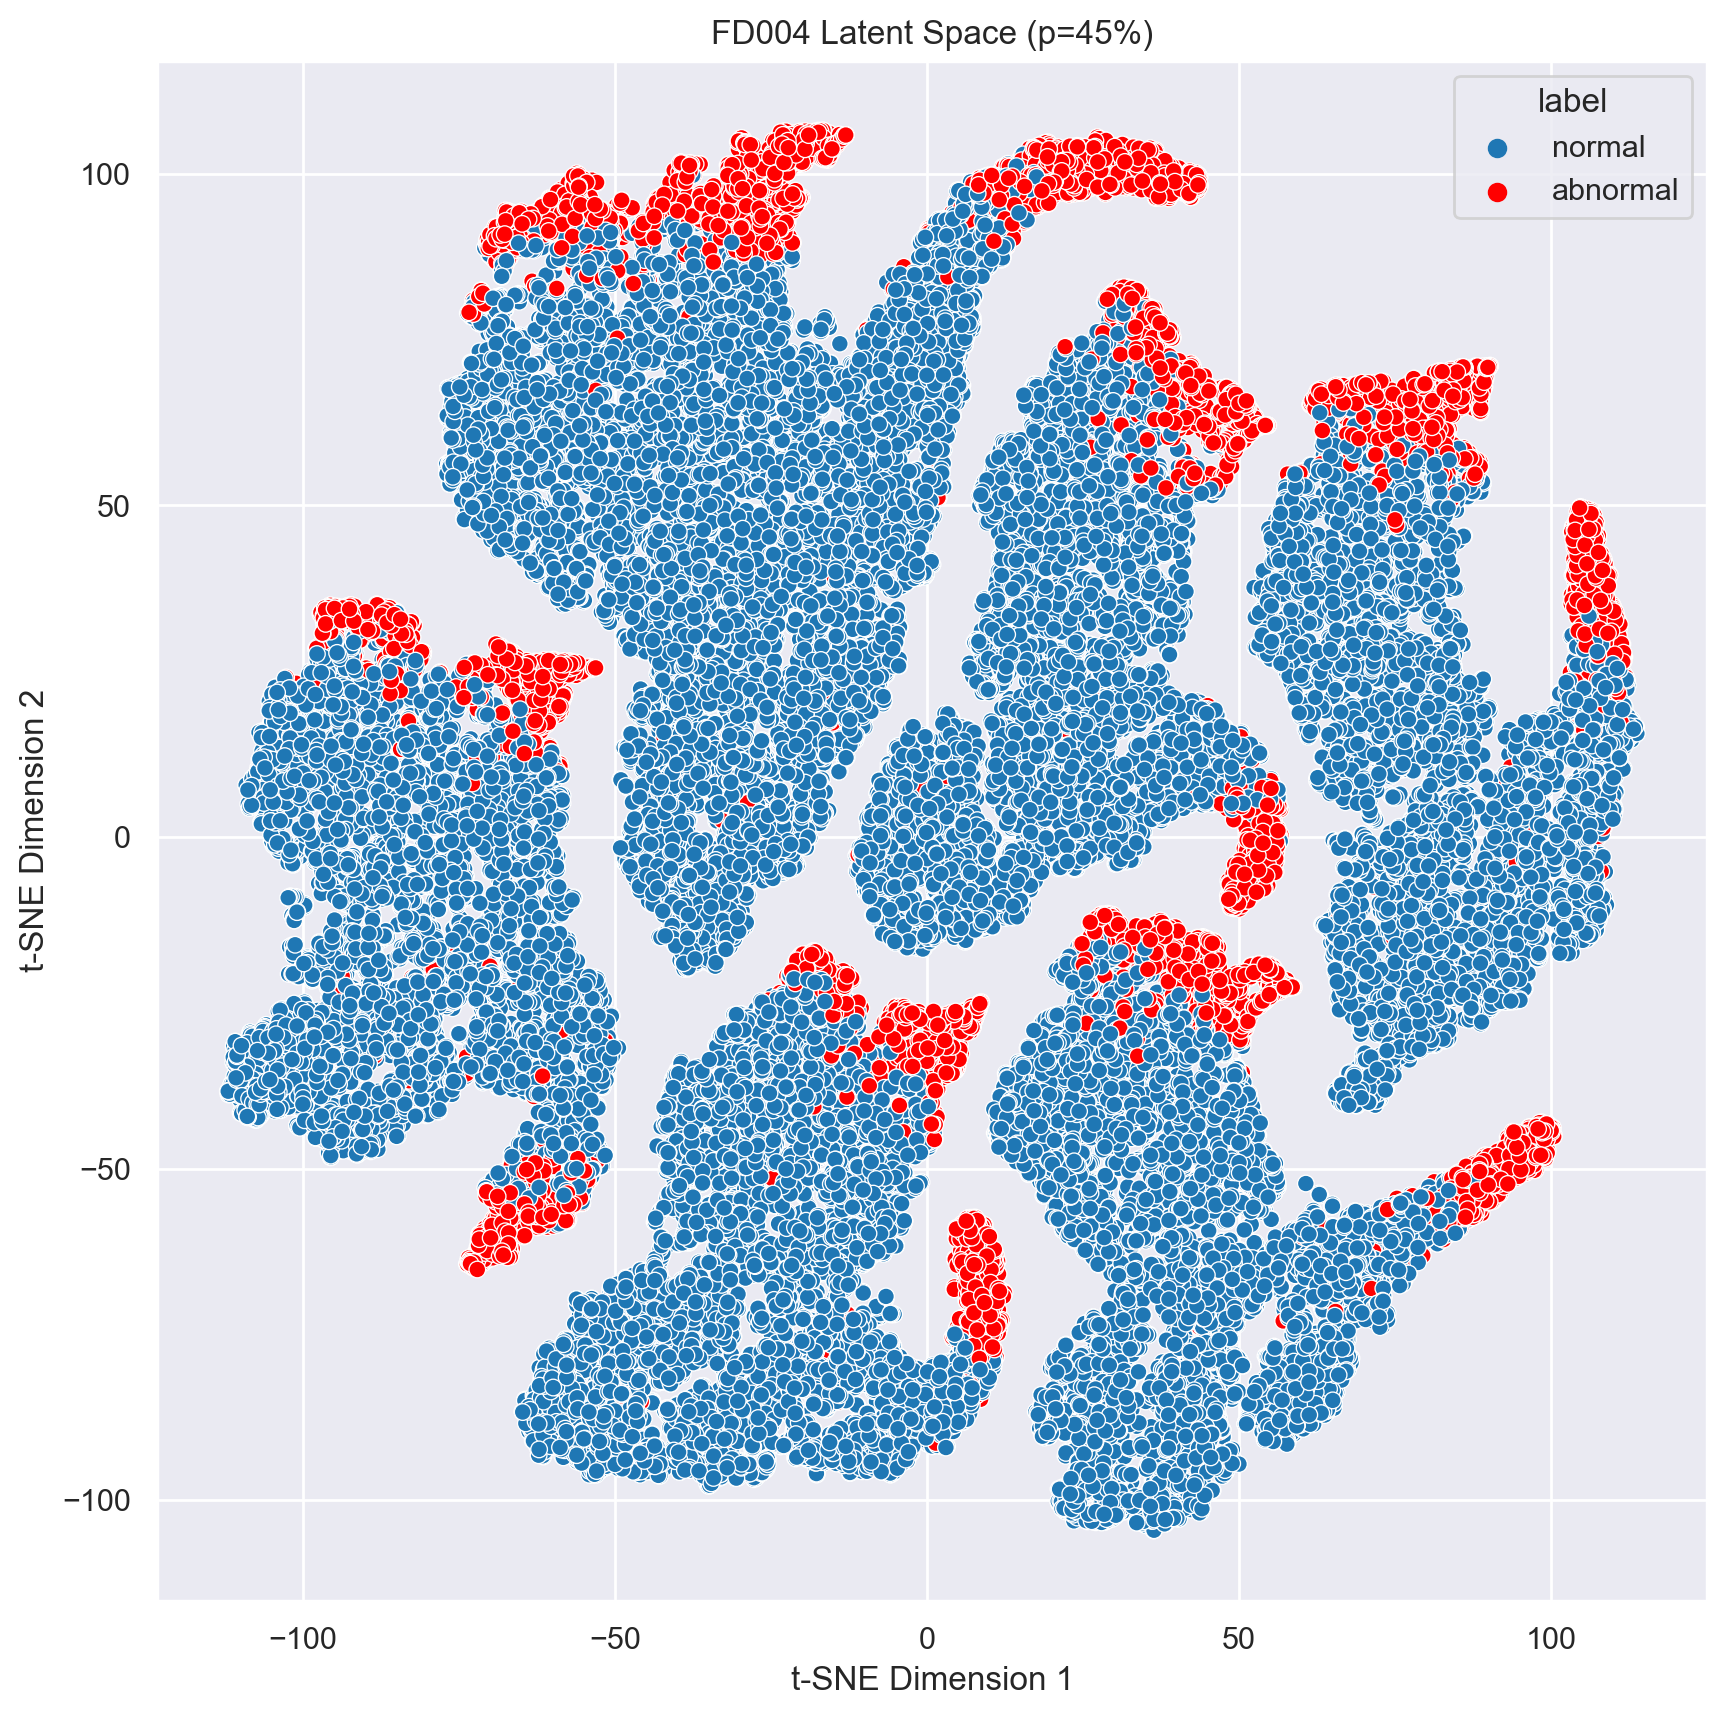

In [16]:
plot_latent_space(df_latent_space, 
                  title=f"{dataset} Latent Space (p={normal_op_len}%)", 
                  x_label="t-SNE Dimension 1", 
                  y_label="t-SNE Dimension 2")

# Visualize one of the training samples

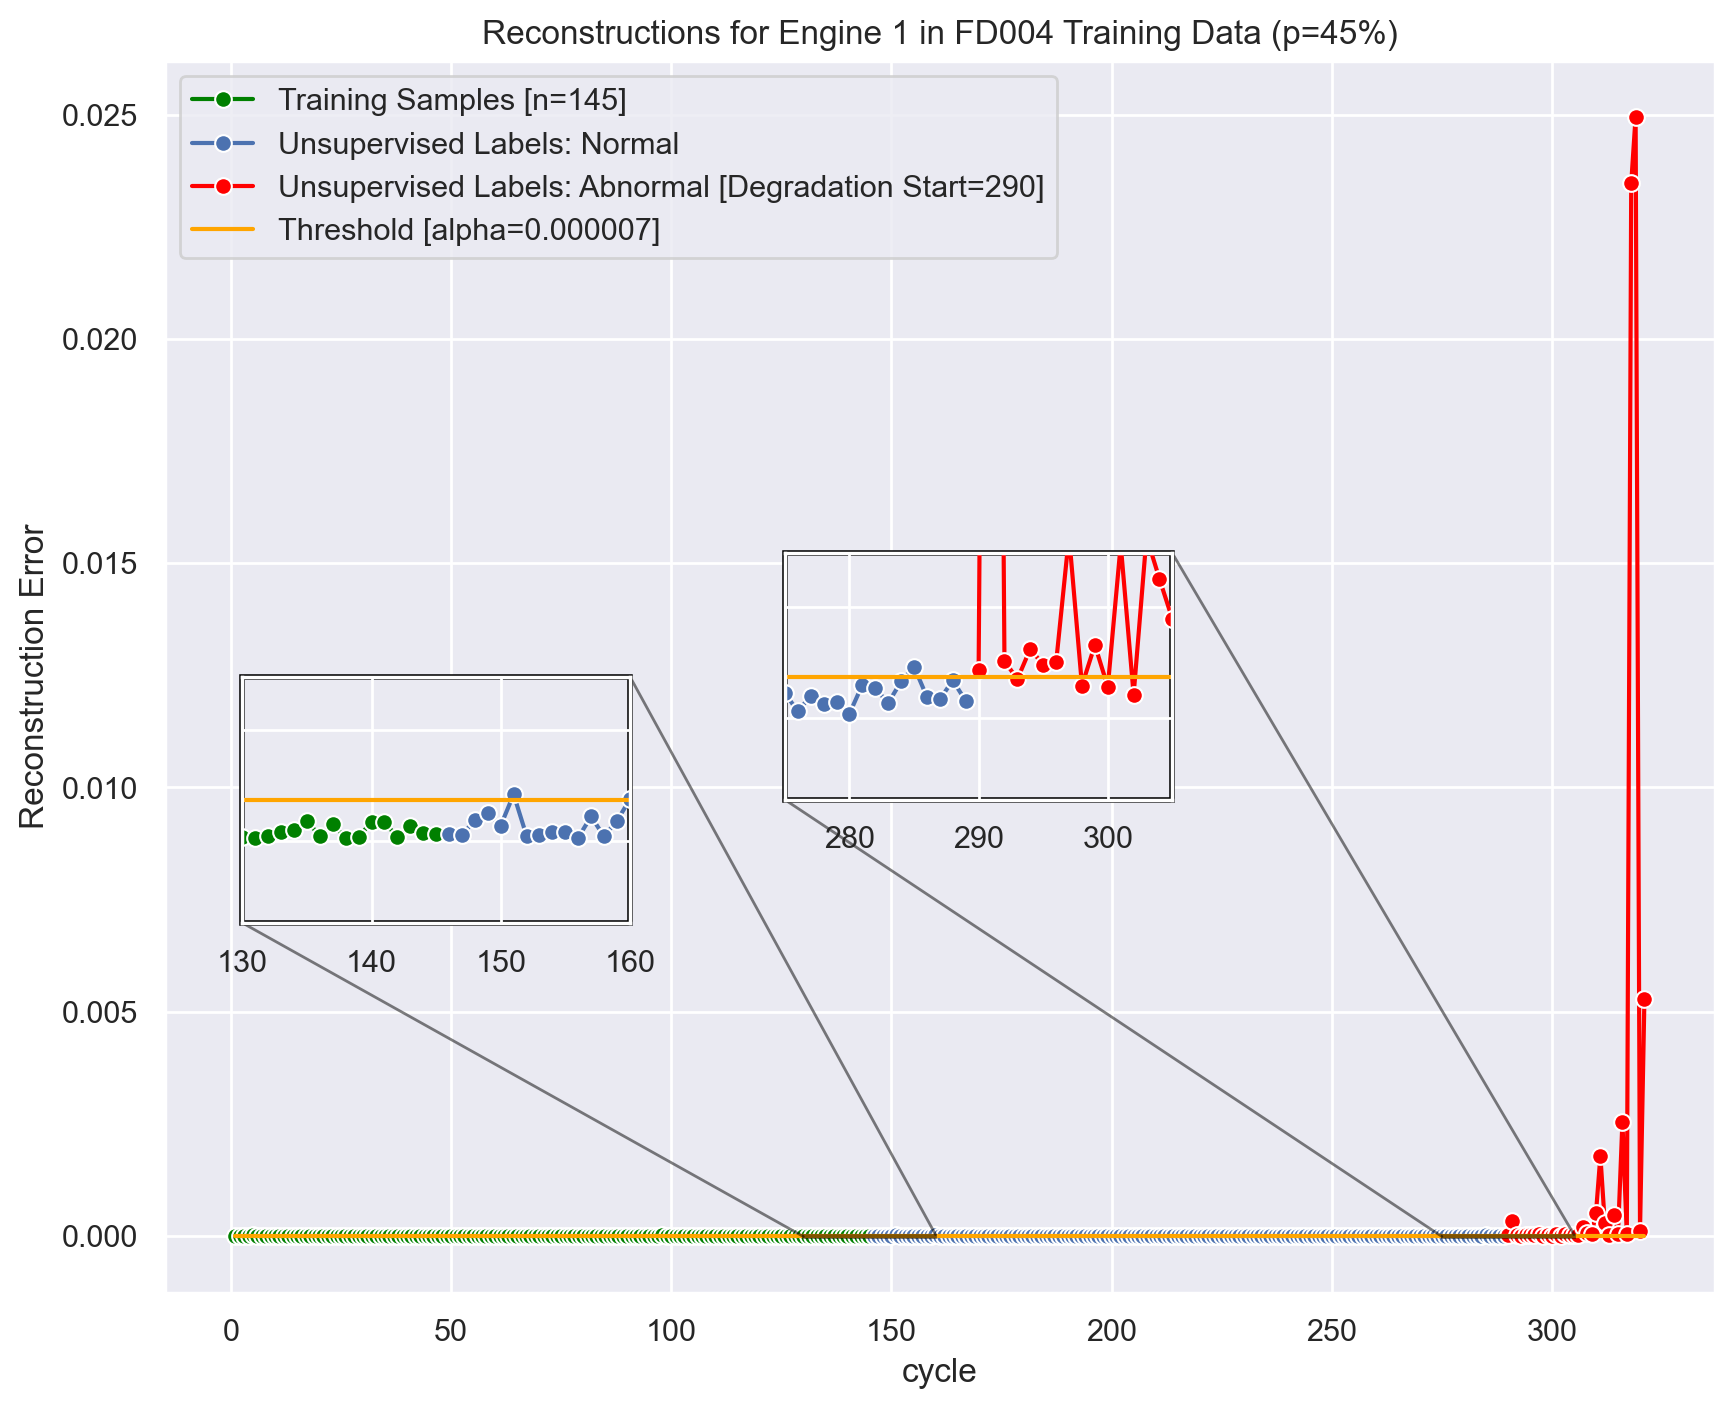

In [17]:
unit = 1
title = f"Reconstructions for Engine {unit} in {dataset} Training Data (p={normal_op_len}%)"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=number_normal_samples, 
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST, 
                                       title=title,
                                       recon_errors_title="Reconstruction Error",
                                       threshold_title=f"Threshold [alpha={unit_threshold:0.6f}]",
                                       x_axis_column="cycle", 
                                       show_zoom_ins=True)

# Visualize a testing sample

In [18]:
for unit in df_unsupervised_labels_testing.query("fault==1")["unit"].unique().tolist():
    print(unit)

8
12
15
22
25
31
32
35
38
40
44
47
49
58
61
62
65
68
69
70
71
73
82
91
100
101
102
111
114
116
118
121
126
135
150
151
155
158
159
173
179
180
181
183
184
194
197
202
206
209
213
216
224
235
237
238
244
248


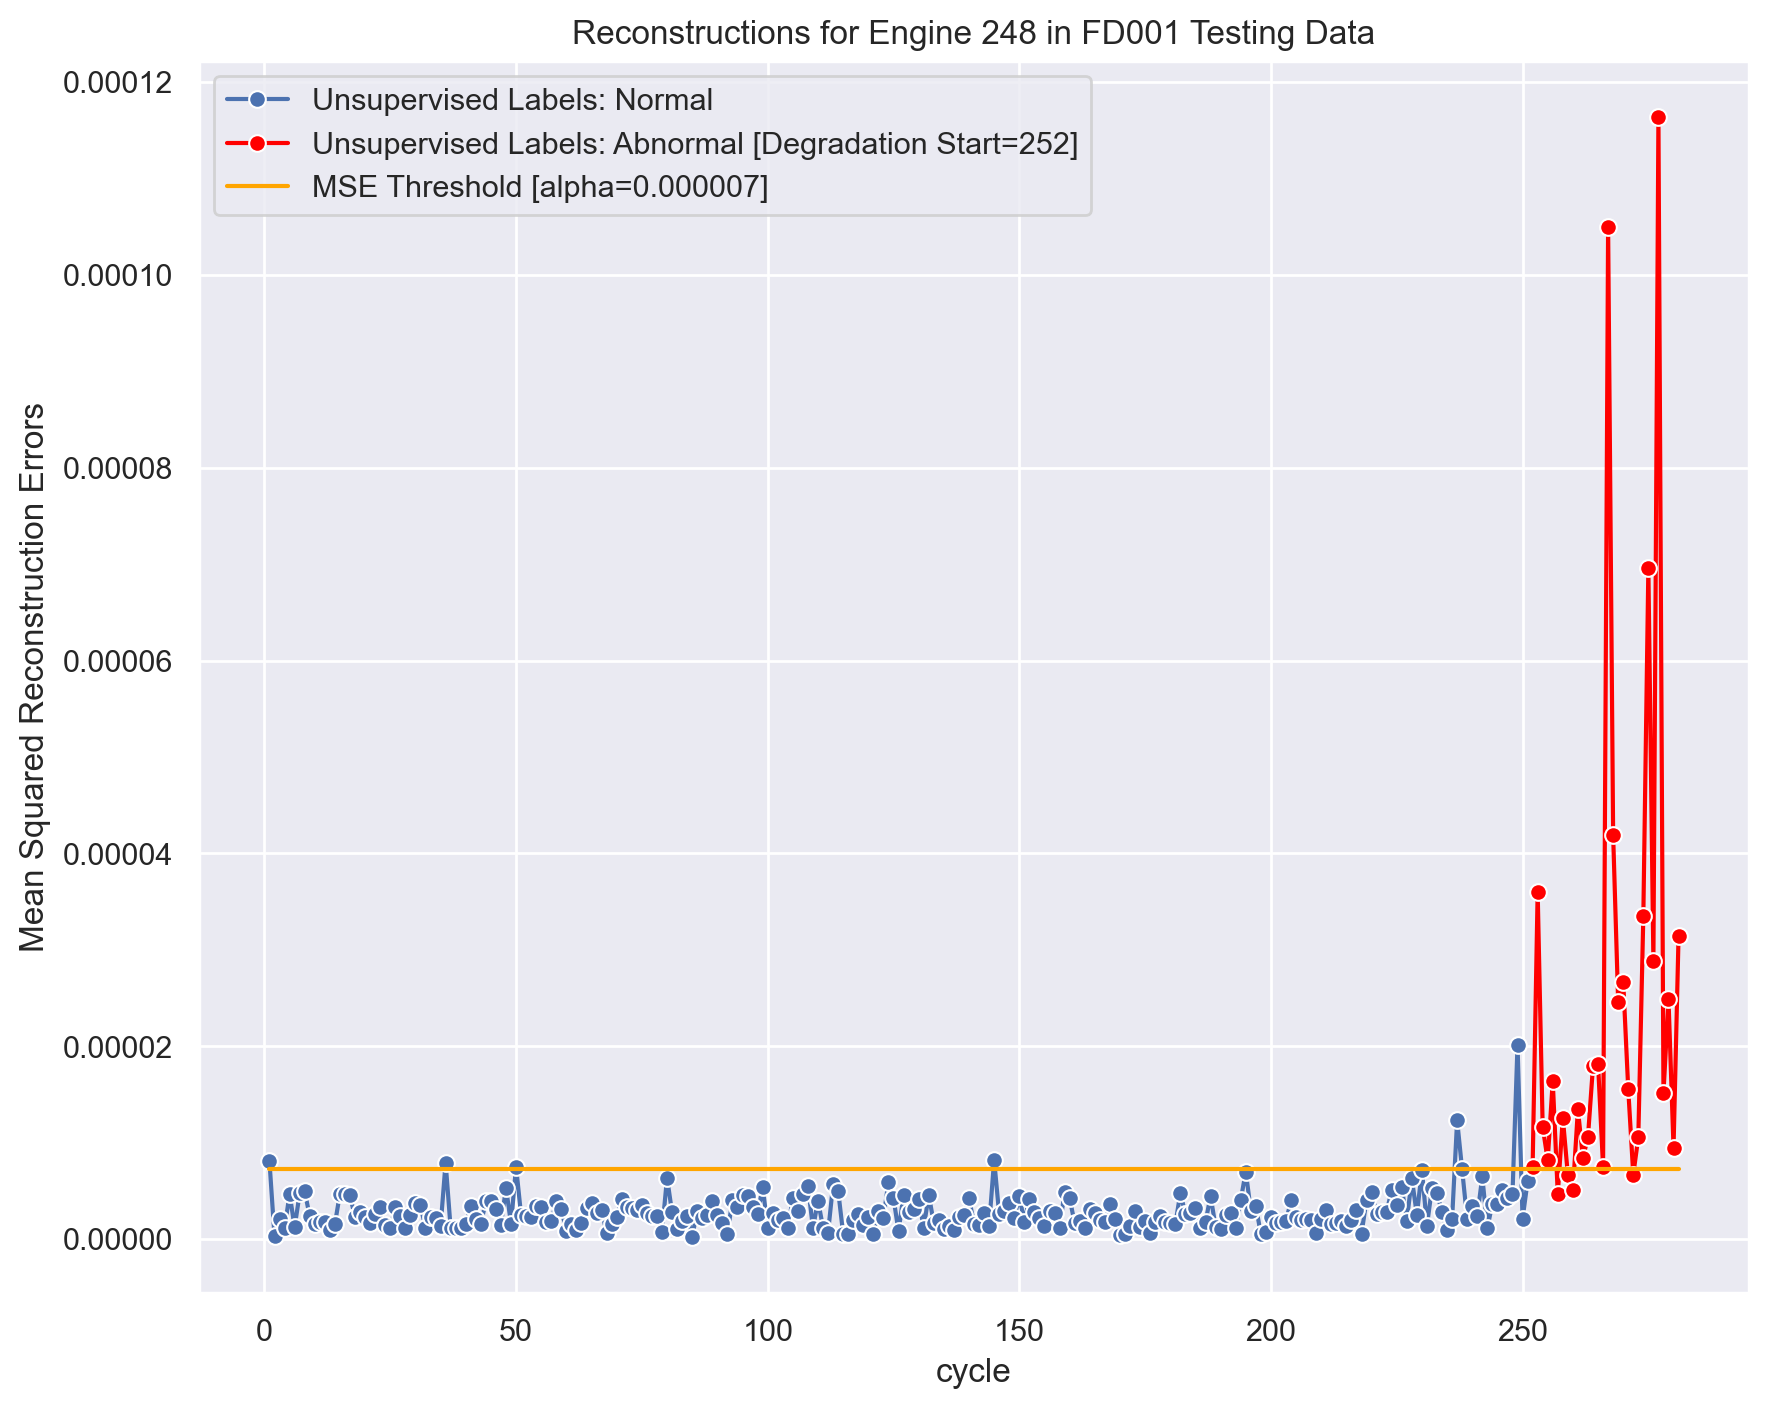

In [23]:
unit = 248
title = f"Reconstructions for Engine {unit} in FD001 Testing Data"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsupervised_labels_testing.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=0,
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST,
                                       title=title,
                                       recon_errors_title="Mean Squared Reconstruction Errors", 
                                       threshold_title=f"MSE Threshold [alpha={unit_threshold:0.6f}]", 
                                       x_axis_column="cycle", 
                                       show_zoom_ins=False)

In [20]:
ruls = []
cycles = []
for unit in list(df_unsuperivsed_labels_training["unit"].unique()):
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit} and fault==1")
    max_rul = df_unit["RUL"].max()
    cycle = df_unit["cycle"].min()
    
    ruls.append(max_rul)
    cycles.append(cycle)

print(f"Smallest Maximum RUL: {min(ruls)}")
print(f"Largets Maximum RUL: {max(ruls)}")
print(f"Average RUL: {np.mean(ruls)}")
print(f"Median RUL: {np.median(ruls)}\n")

print(f"Smallest Cycle: {min(cycles)}")
print(f"Largest Cycle: {max(cycles)}")
print(f"Average Cycle: {np.mean(cycles)}")
print(f"Median Cycle: {np.median(cycles)}")
# print(f"Largest_RUL + Median_RUL = {np.median(ruls) + max(ruls)}")

Smallest Maximum RUL: 8
Largets Maximum RUL: 224
Average RUL: 37.19277108433735
Median RUL: 32.0

Smallest Cycle: 105
Largest Cycle: 458
Average Cycle: 208.7871485943775
Median Cycle: 196.0


Smallest Cycle where a Fault Started: 105
Largest Cycle where a Fault Started: 458
Number of samples: 249


<Axes: ylabel='Count'>

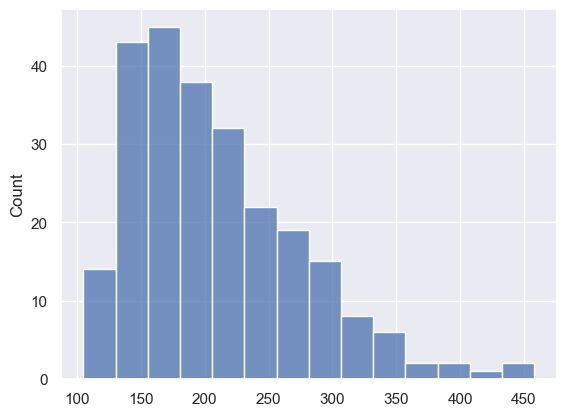

In [21]:
fault_start_training_data = []
for eng in df_unsuperivsed_labels_training["unit"].unique().tolist():
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_training_data.append(unit_fault_start)
    
print(f"Smallest Cycle where a Fault Started: {min(fault_start_training_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_training_data)}")
print(f"Number of samples: {len(fault_start_training_data)}")
sns.histplot(fault_start_training_data)

Smallest Cycle where a Fault Started: 12
Largest Cycle where a Fault Started: 416
Number of samples: 58


<Axes: ylabel='Count'>

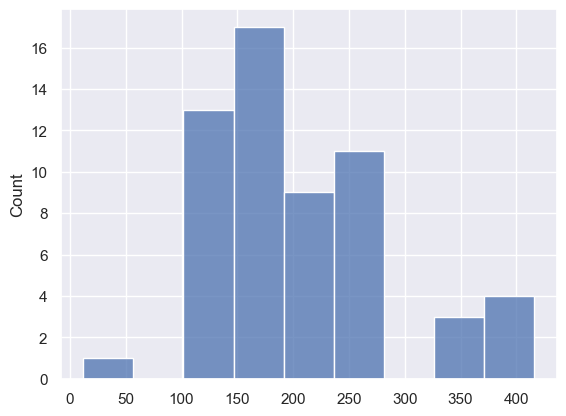

In [22]:
fault_start_testing_data = []
for eng in df_unsupervised_labels_testing["unit"].unique().tolist():
    df_unit = df_unsupervised_labels_testing.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_testing_data.append(unit_fault_start)
        
        if unit_fault_start == 1:
            print(f"Unit={eng}")

print(f"Smallest Cycle where a Fault Started: {min(fault_start_testing_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_testing_data)}")
print(f"Number of samples: {len(fault_start_testing_data)}")
sns.histplot(fault_start_testing_data)